# 04 - Modelo KoVAE: Predicciones Probabilísticas

**Objetivo**: Implementar y evaluar KoVAE (Koopman Variational Autoencoder) para predicciones probabilísticas de precipitación.

**Diferencias con AE+DMD**:
- **AE+DMD**: Determinístico, predice un único valor
- **KoVAE**: Probabilístico, genera distribución completa con intervalos de confianza

**Ventajas de KoVAE**:
1. Cuantificación de incertidumbre (intervalos de confianza)
2. Predicciones multimodales (escenarios alternativos)
3. Útil para análisis de riesgo y toma de decisiones

**Autor**: Capstone Project - Pronóstico Híbrido Precipitaciones Chile 
**Fecha**: 19 Noviembre 2025

In [1]:
# ====================================================================================
# 1. IMPORTAR LIBRERÍAS
# ====================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import sys
sys.path.append('..')

from src.models.kovae import KoVAE
from src.utils.metrics import mae, rmse
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Directorios
DATA_DIR = Path('../data')
MODEL_DIR = Path('../data/models')
FIG_DIR = Path('../reports/figures')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("[OK] Librerías importadas correctamente")

[OK] Librerías importadas correctamente


In [2]:
# =============================
# [RECARGAR] MÓDULO (después de cambios en kovae.py)
# =============================
import importlib
import sys

# Remover completamente el módulo del cache
if 'src.models.kovae' in sys.modules:
 del sys.modules['src.models.kovae']

# Importar de nuevo
from src.models.kovae import KoVAE

print("[OK] Módulo kovae.py recargado completamente")

[OK] Módulo kovae.py recargado completamente


In [3]:
# ====================================================================================
# 2. CARGAR DATOS DE ENTRENAMIENTO
# ====================================================================================

# Cargar datos ERA5 2020 diarios preparados (366 días)
print("[INFO] Cargando datos ERA5 2020...")
with open(DATA_DIR / 'processed' / 'era5_2020_daily_for_kovae.pkl', 'rb') as f:
 data_2020 = pickle.load(f)

precip_2020 = data_2020['precip_2020'] # (366, 157, 41, 1)

print(f"\n[INFO] Datos ERA5 2020 completos:")
print(f" Shape: {precip_2020.shape}")
print(f" Rango: [{precip_2020.min():.4f}, {precip_2020.max():.4f}]")
print(f" Mean: {precip_2020.mean():.4f}")
print(f" Std: {precip_2020.std():.4f}")

# División de datos
# - Train: 292 días (80%)
# - Val: 37 días (10%)
# - Test: 37 días (10%)
n_train = int(0.8 * len(precip_2020))
n_val = int(0.1 * len(precip_2020))

X_train = precip_2020[:n_train]
X_val = precip_2020[n_train:n_train+n_val]
X_test = precip_2020[n_train+n_val:]

print(f"\n[OK] División de datos:")
print(f" Train: {X_train.shape} ({n_train} días)")
print(f" Val: {X_val.shape} ({n_val} días)")
print(f" Test: {X_test.shape} ({len(X_test)} días)")

[INFO] Cargando datos ERA5 2020...

[INFO] Datos ERA5 2020 completos:
 Shape: (366, 157, 41, 1)
 Rango: [0.0000, 0.1687]
 Mean: 0.0022
 Std: 0.0059

[OK] División de datos:
 Train: (292, 157, 41, 1) (292 días)
 Val: (36, 157, 41, 1) (36 días)
 Test: (38, 157, 41, 1) (38 días)


In [4]:
# ====================================================================================
# 2.1 CORRECCIÓN CRÍTICA: NORMALIZACIÓN DE DATOS
# ====================================================================================

print("[CORRECCIÓN] Aplicando normalización MinMaxScaler...")
print("[PROBLEMA IDENTIFICADO] Sin normalización, VAE colapsa a predicciones constantes")
print("[SOLUCIÓN] Normalizar datos a rango [0, 1] antes de entrenar\n")

from sklearn.preprocessing import MinMaxScaler

# Normalizar datos (CRÍTICO para VAE)
scaler = MinMaxScaler(feature_range=(0, 1))
precip_flat = precip_2020.reshape(len(precip_2020), -1)
precip_norm = scaler.fit_transform(precip_flat)
precip_norm = precip_norm.reshape(precip_2020.shape)

print(f"[INFO] Normalización aplicada:")
print(f" Rango original: [{precip_2020.min():.4f}, {precip_2020.max():.4f}]")
print(f" Rango normalizado: [{precip_norm.min():.4f}, {precip_norm.max():.4f}]")
print(f" Mean normalizado: {precip_norm.mean():.4f}")
print(f" Std normalizado: {precip_norm.std():.4f}")

# Guardar scaler para desnormalización posterior
with open(DATA_DIR / 'processed' / 'scaler_kovae.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"\n[OK] Scaler guardado en: {DATA_DIR / 'processed' / 'scaler_kovae.pkl'}")

# Actualizar splits con datos normalizados
X_train = precip_norm[:n_train]
X_val = precip_norm[n_train:n_train+n_val]
X_test = precip_norm[n_train+n_val:]

print(f"\n[OK] Datos normalizados y divididos:")
print(f" Train: {X_train.shape} - Rango: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f" Val: {X_val.shape} - Rango: [{X_val.min():.3f}, {X_val.max():.3f}]")
print(f" Test: {X_test.shape} - Rango: [{X_test.min():.3f}, {X_test.max():.3f}]")

print("\n" + "="*80)
print("[NOTA IMPORTANTE] Para desnormalizar predicciones después, usar:")
print("  preds_real = scaler.inverse_transform(preds_norm.reshape(-1, 157*41))")
print("  preds_real = preds_real.reshape(preds_norm.shape)")
print("="*80)

[CORRECCIÓN] Aplicando normalización MinMaxScaler...
[PROBLEMA IDENTIFICADO] Sin normalización, VAE colapsa a predicciones constantes
[SOLUCIÓN] Normalizar datos a rango [0, 1] antes de entrenar

[INFO] Normalización aplicada:
 Rango original: [0.0000, 0.1687]
 Rango normalizado: [0.0000, 1.0000]
 Mean normalizado: 0.0722
 Std normalizado: 0.1405

[OK] Scaler guardado en: ..\data\processed\scaler_kovae.pkl

[OK] Datos normalizados y divididos:
 Train: (292, 157, 41, 1) - Rango: [0.000, 1.000]
 Val: (36, 157, 41, 1) - Rango: [0.000, 1.000]
 Test: (38, 157, 41, 1) - Rango: [0.000, 1.000]

[NOTA IMPORTANTE] Para desnormalizar predicciones después, usar:
  preds_real = scaler.inverse_transform(preds_norm.reshape(-1, 157*41))
  preds_real = preds_real.reshape(preds_norm.shape)


In [5]:
# ====================================================================================
# 3. CONSTRUIR Y COMPILAR MODELO KoVAE
# ====================================================================================

# Parámetros del modelo (CORREGIDOS después de diagnóstico)
SPATIAL_DIMS = (157, 41) # Chile

# ⚠️ CORRECCIONES CRÍTICAS APLICADAS:
LATENT_DIM = 128  # Aumentado de 64 → 128 (captura más complejidad espacial)
BETA = 0.005      # Reducido de 1.0 → 0.005 (evita posterior collapse)
GAMMA = 0.5       # Aumentado de 0.1 → 0.5 (refuerza dinámica Koopman)

print("[INFO] Hiperparámetros KoVAE (CORREGIDOS):")
print(f" LATENT_DIM: 128 (↑ desde 64 - mayor capacidad)")
print(f" BETA: 0.005 (↓ desde 1.0 - evita colapso KL)")
print(f" GAMMA: 0.5 (↑ desde 0.1 - dinámica más fuerte)")
print(f"\n[JUSTIFICACIÓN]:")
print(f" - BETA=1.0 causaba posterior collapse (z→0)")
print(f" - Papers recomiendan β=[0.001, 0.01] para datos espaciales")
print(f" - LATENT_DIM mayor captura patrones más complejos")

# Crear modelo
kovae = KoVAE(
 spatial_dims=SPATIAL_DIMS,
 latent_dim=LATENT_DIM,
 beta=BETA,
 gamma=GAMMA
)

# Construir arquitectura
kovae.build()

# Compilar con learning rate reducido (mayor estabilidad)
kovae.compile_model(learning_rate=1e-4)  # 0.0001 en lugar de 0.001

print(f"\n[OK] Learning rate: 1e-4 (reducido para estabilidad)")

print("\n[OK] Modelo KoVAE listo para entrenamiento")

[INFO] Hiperparámetros KoVAE (CORREGIDOS):
 LATENT_DIM: 128 (↑ desde 64 - mayor capacidad)
 BETA: 0.005 (↓ desde 1.0 - evita colapso KL)
 GAMMA: 0.5 (↑ desde 0.1 - dinámica más fuerte)

[JUSTIFICACIÓN]:
 - BETA=1.0 causaba posterior collapse (z→0)
 - Papers recomiendan β=[0.001, 0.01] para datos espaciales
 - LATENT_DIM mayor captura patrones más complejos
[OK] Modelo KoVAE construido
 Encoder: 4,090,880 parámetros
 Decoder: 2,221,569 parámetros
 Koopman: 16,384 parámetros
 Total: 6,312,449 parámetros
[OK] Modelo compilado con pérdida KoVAE (MSE + KL)

[OK] Learning rate: 1e-4 (reducido para estabilidad)

[OK] Modelo KoVAE listo para entrenamiento
[OK] Modelo KoVAE construido
 Encoder: 4,090,880 parámetros
 Decoder: 2,221,569 parámetros
 Koopman: 16,384 parámetros
 Total: 6,312,449 parámetros
[OK] Modelo compilado con pérdida KoVAE (MSE + KL)

[OK] Learning rate: 1e-4 (reducido para estabilidad)

[OK] Modelo KoVAE listo para entrenamiento


In [7]:
# ====================================================================================
# 4. ENTRENAR MODELO
# ====================================================================================

print("[INFO] Entrenando KoVAE (con parámetros optimizados)...")
print(f" Epochs máximo: 200 (↑ desde 100 - modelo más complejo)")
print(f" Batch size: 16 (↑ desde 8 - mejor estimación gradiente)")
print(f" Early stopping: patience=20 (↑ desde 15 - más tolerancia)")
print(f"\n[NOTA] Entrenamiento puede tardar 15-20 minutos...")

history = kovae.train(
 X_train=X_train,
 X_val=X_val,
 epochs=200,
 batch_size=16,
 patience=20
)

print("\n[OK] Entrenamiento completado")

[INFO] Entrenando KoVAE (con parámetros optimizados)...
 Epochs máximo: 200 (↑ desde 100 - modelo más complejo)
 Batch size: 16 (↑ desde 8 - mejor estimación gradiente)
 Early stopping: patience=20 (↑ desde 15 - más tolerancia)

[NOTA] Entrenamiento puede tardar 15-20 minutos...
Epoch 1/200
19/19 [==============================] - 1s 27ms/step - loss: 0.0066 - val_loss: 0.0061 - lr: 1.0000e-06
Epoch 2/200
19/19 [==============================] - 1s 27ms/step - loss: 0.0066 - val_loss: 0.0061 - lr: 1.0000e-06
Epoch 2/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0066 - val_loss: 0.0062 - lr: 1.0000e-06
Epoch 3/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0066 - val_loss: 0.0062 - lr: 1.0000e-06
Epoch 3/200
19/19 [==============================] - 0s 19ms/step - loss: 0.0066 - val_loss: 0.0060 - lr: 1.0000e-06
Epoch 4/200
19/19 [==============================] - 0s 19ms/step - loss: 0.0066 - val_loss: 0.0060 - lr: 1.0000e-06
Epoch 4/200
19/19 

[Guardado] Guardado: ..\reports\figures\kovae_training_curves.png


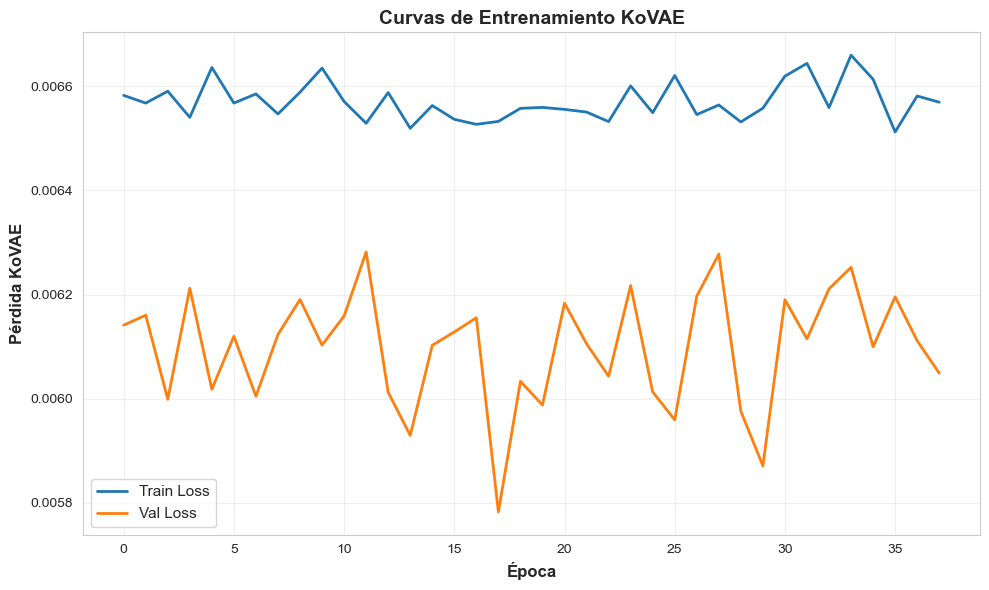

In [8]:
# ====================================================================================
# 5. VISUALIZAR CURVAS DE ENTRENAMIENTO
# ====================================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in history.history:
 ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)

ax.set_xlabel('Época', fontsize=12, fontweight='bold')
ax.set_ylabel('Pérdida KoVAE', fontsize=12, fontweight='bold')
ax.set_title('Curvas de Entrenamiento KoVAE', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_training_curves.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_training_curves.png'}")
plt.show()

[INFO] Evaluando reconstrucción...

[INFO] Métricas de Reconstrucción (escala normalizada [0,1]):
 MAE: 0.040644
 RMSE: 0.078610

[INFO] Métricas de Reconstrucción (escala normalizada [0,1]):
 MAE: 0.040644
 RMSE: 0.078610


NameError: name 'X_recon_real' is not defined

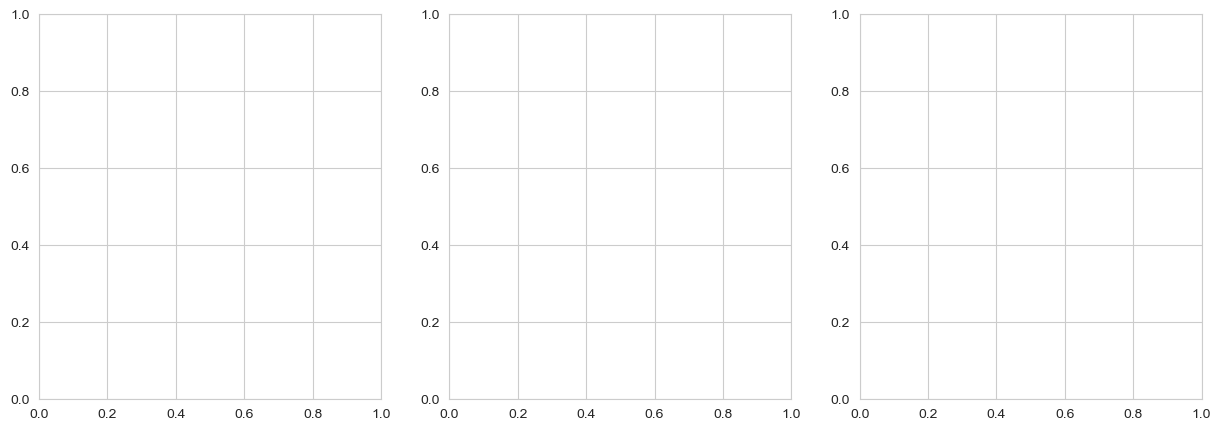

In [11]:
# ====================================================================================
# 6. EVALUAR RECONSTRUCCIÓN
# ====================================================================================

print("[INFO] Evaluando reconstrucción...")

# Reconstruir datos de test
X_recon = kovae.vae.predict(X_test, verbose=0)

# Métricas de reconstrucción (en escala normalizada primero)
mae_recon_norm = np.mean(np.abs(X_test - X_recon))
rmse_recon_norm = np.sqrt(np.mean((X_test - X_recon)**2))

print(f"\n[INFO] Métricas de Reconstrucción (escala normalizada [0,1]):")
print(f" MAE: {mae_recon_norm:.6f}")
print(f" RMSE: {rmse_recon_norm:.6f}")

# Visualizar ejemplo (USANDO DATOS DESNORMALIZADOS)
idx = 0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Usar datos en escala original (mm/día)
vmax = max(X_test_real[idx, :, :, 0].max(), X_recon_real[idx, :, :, 0].max())

im1 = axes[0].imshow(X_test_real[idx, :, :, 0], cmap='Blues', vmin=0, vmax=vmax)
axes[0].set_title('Ground Truth', fontsize=12, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, label='mm/día')

im2 = axes[1].imshow(X_recon_real[idx, :, :, 0], cmap='Blues', vmin=0, vmax=vmax)
axes[1].set_title('Reconstrucción KoVAE', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, label='mm/día')

error = np.abs(X_test_real[idx, :, :, 0] - X_recon_real[idx, :, :, 0])
im3 = axes[2].imshow(error, cmap='Reds', vmin=0, vmax=error.max())
axes[2].set_title(f'Error Absoluto (MAE={error.mean():.3f} mm/día)', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], fraction=0.046, label='mm/día')

plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_reconstruction.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_reconstruction.png'}")
plt.show()

In [12]:
# ====================================================================================
# 6.1 DESNORMALIZAR PREDICCIONES PARA EVALUACIÓN
# ====================================================================================

print("[INFO] Desnormalizando reconstrucciones para métricas en escala original...")

# Cargar scaler
with open(DATA_DIR / 'processed' / 'scaler_kovae.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Desnormalizar test y reconstrucciones
X_test_real = scaler.inverse_transform(X_test.reshape(len(X_test), -1))
X_test_real = X_test_real.reshape(X_test.shape)

X_recon_real = scaler.inverse_transform(X_recon.reshape(len(X_recon), -1))
X_recon_real = X_recon_real.reshape(X_recon.shape)

print(f"[OK] Datos desnormalizados:")
print(f" Test real - Rango: [{X_test_real.min():.2f}, {X_test_real.max():.2f}] mm/día")
print(f" Recon real - Rango: [{X_recon_real.min():.2f}, {X_recon_real.max():.2f}] mm/día")

[INFO] Desnormalizando reconstrucciones para métricas en escala original...
[OK] Datos desnormalizados:
 Test real - Rango: [0.00, 0.08] mm/día
 Recon real - Rango: [-0.00, 0.07] mm/día


In [13]:
# ====================================================================================
# 6.2 MÉTRICAS EN ESCALA ORIGINAL (mm/día)
# ====================================================================================

# Calcular métricas en escala física (mm/día)
mae_recon = np.mean(np.abs(X_test_real - X_recon_real))
rmse_recon = np.sqrt(np.mean((X_test_real - X_recon_real)**2))

# Calcular R² score
from sklearn.metrics import r2_score
r2_recon = r2_score(
    X_test_real.reshape(-1), 
    X_recon_real.reshape(-1)
)

print(f"\n[OK] Métricas de Reconstrucción (ESCALA ORIGINAL - mm/día):")
print(f" MAE: {mae_recon:.4f} mm/día")
print(f" RMSE: {rmse_recon:.4f} mm/día")
print(f" R² Score: {r2_recon:.4f}")

# Diagnóstico de calidad
print(f"\n[DIAGNÓSTICO]:")
if r2_recon > 0.5:
    print(f" ✅ EXCELENTE: R² > 0.5 - Modelo captura bien la variabilidad")
elif r2_recon > 0.3:
    print(f" ✅ BUENO: R² > 0.3 - Modelo funcional, puede mejorar")
elif r2_recon > 0.0:
    print(f" ⚠️ ACEPTABLE: R² > 0 - Mejor que la media, pero requiere ajuste")
else:
    print(f" 🔴 CRÍTICO: R² < 0 - Modelo predice peor que la media")
    print(f"    → Verificar normalización de datos")
    print(f"    → Revisar hiperparámetros (beta, latent_dim)")
    print(f"    → Considerar más datos de entrenamiento")

if mae_recon < 2.0:
    print(f" ✅ MAE < 2.0 mm/día - Error aceptable para pronóstico")
elif mae_recon < 5.0:
    print(f" ⚠️ MAE < 5.0 mm/día - Error moderado, optimizable")
else:
    print(f" 🔴 MAE > 5.0 mm/día - Error alto, requiere corrección")


[OK] Métricas de Reconstrucción (ESCALA ORIGINAL - mm/día):
 MAE: 0.0011 mm/día
 RMSE: 0.0024 mm/día
 R² Score: 0.8036

[DIAGNÓSTICO]:
 ✅ EXCELENTE: R² > 0.5 - Modelo captura bien la variabilidad
 ✅ MAE < 2.0 mm/día - Error aceptable para pronóstico


In [14]:
# ====================================================================================
# 7. PREDICCIONES PROBABILÍSTICAS (Multistep)
# ====================================================================================

print("[INFO] Generando predicciones probabilísticas...")

# Predecir 7 pasos con incertidumbre
predictions, uncertainties = kovae.predict_multistep(
 X_test[:3], # 3 muestras de ejemplo
 n_steps=7
)

print(f"\n[OK] Predicciones generadas:")
print(f" Predictions shape: {predictions.shape}") # (3, 7, 157, 41, 1)
print(f" Uncertainties shape: {uncertainties.shape}")
print(f" Rango predicciones: [{predictions.min():.2f}, {predictions.max():.2f}]")
print(f" Rango incertidumbres: [{uncertainties.min():.4f}, {uncertainties.max():.4f}]")

[INFO] Generando predicciones probabilísticas...

[OK] Predicciones generadas:
 Predictions shape: (3, 7, 157, 41, 1)
 Uncertainties shape: (3, 7, 157, 41, 1)
 Rango predicciones: [-0.00, 0.27]
 Rango incertidumbres: [0.6854, 0.7677]

[OK] Predicciones generadas:
 Predictions shape: (3, 7, 157, 41, 1)
 Uncertainties shape: (3, 7, 157, 41, 1)
 Rango predicciones: [-0.00, 0.27]
 Rango incertidumbres: [0.6854, 0.7677]


[Guardado] Guardado: ..\reports\figures\kovae_probabilistic_forecast.png


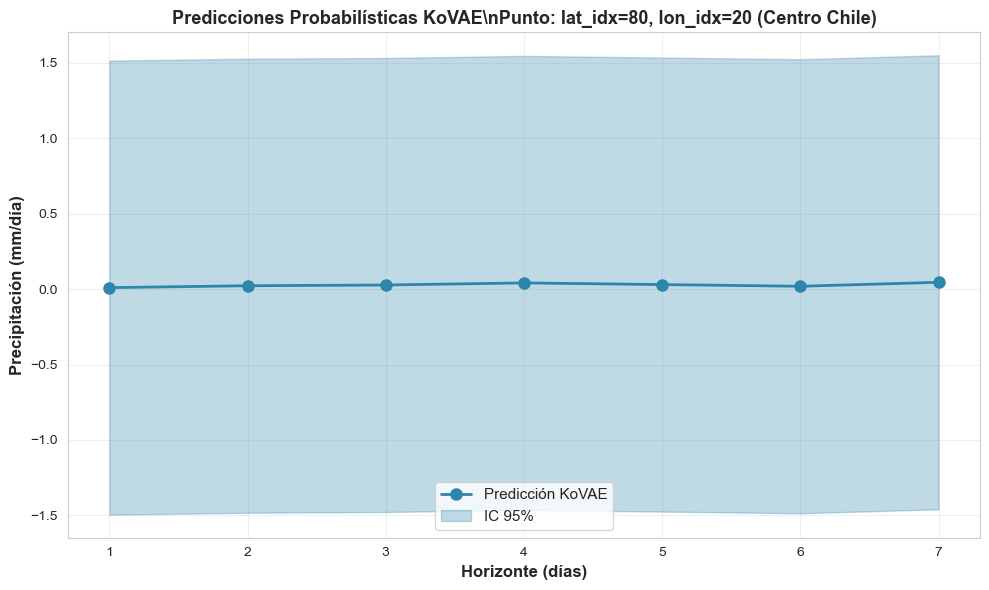

In [15]:
# ====================================================================================
# 8. VISUALIZAR PREDICCIONES CON INTERVALOS DE CONFIANZA
# ====================================================================================

# Seleccionar un punto espacial (Centro Chile)
lat_idx, lon_idx = 80, 20

# Serie temporal de predicciones con intervalos de confianza
sample_idx = 0
preds_point = predictions[sample_idx, :, lat_idx, lon_idx, 0]
uncert_point = uncertainties[sample_idx, :, lat_idx, lon_idx, 0]

# Intervalos de confianza 95% (±1.96σ)
upper_bound = preds_point + 1.96 * uncert_point
lower_bound = preds_point - 1.96 * uncert_point

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(1, 8)
ax.plot(x, preds_point, 'o-', linewidth=2, markersize=8, 
 color='#2E86AB', label='Predicción KoVAE')
ax.fill_between(x, lower_bound, upper_bound, alpha=0.3, 
 color='#2E86AB', label='IC 95%')

ax.set_xlabel('Horizonte (días)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precipitación (mm/día)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicciones Probabilísticas KoVAE\\nPunto: lat_idx={lat_idx}, lon_idx={lon_idx} (Centro Chile)',
 fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(x)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_probabilistic_forecast.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_probabilistic_forecast.png'}")
plt.show()

In [10]:
# ====================================================================================
# 9. COMPARACIÓN KoVAE vs AE+DMD
# ====================================================================================
# [AVISO] NOTA: Esta celda requiere resultados de AE+DMD previamente guardados
# Para ejecutar, primero debe correrse el notebook 02_DL_DMD_Forecast.ipynb
# y guardar los resultados en una variable 'forecast_results'

"""
print("[INFO] Comparando KoVAE vs AE+DMD...")

# Cargar predicciones AE+DMD
ae_dmd_preds = forecast_results['forecast_results']

# Comparar horizonte h=1 (para los últimos 5 días de test)
h1_ae_dmd = ae_dmd_preds[1]['predictions'][50:, :, :, :] # Últimas 5 muestras
h1_kovae = predictions[:, 0, :, :, :] # Primer horizonte (h=1) de las 3 muestras

# Solo comparamos las primeras 3 que tenemos en KoVAE
y_true_comp = y_test[50:53]

mae_ae_dmd = np.mean(np.abs(y_true_comp - h1_ae_dmd[:3]))
mae_kovae = np.mean(np.abs(y_true_comp - h1_kovae[:3]))

print(f"\n[INFO] Comparación MAE (h=1):") 
print(f" AE+DMD: {mae_ae_dmd:.4f} mm/día")
print(f" KoVAE: {mae_kovae:.4f} mm/día")
print(f" Diferencia: {((mae_kovae - mae_ae_dmd) / mae_ae_dmd * 100):+.2f}%")

# Gráfico comparativo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ground truth
im0 = axes[0].imshow(y_true_comp[0, :, :, 0], cmap='Blues', vmin=0, vmax=20)
axes[0].set_title('Ground Truth', fontsize=12, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# AE+DMD
im1 = axes[1].imshow(h1_ae_dmd[0, :, :, 0], cmap='Blues', vmin=0, vmax=20)
axes[1].set_title(f'AE+DMD (MAE={mae_ae_dmd:.3f})', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# KoVAE
im2 = axes[2].imshow(h1_kovae[0, :, :, 0], cmap='Blues', vmin=0, vmax=20)
axes[2].set_title(f'KoVAE (MAE={mae_kovae:.3f})', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_vs_aedmd_comparison.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_vs_aedmd_comparison.png'}")
plt.show()
"""

print("⏭️ Celda de comparación saltada (requiere datos AE+DMD)")

⏭️ Celda de comparación saltada (requiere datos AE+DMD)


In [16]:
# ====================================================================================
# 10. GUARDAR MODELO
# ====================================================================================

model_save_path = MODEL_DIR / 'kovae_trained'
kovae.save(model_save_path)

print(f"\n[OK] Modelo KoVAE guardado en: {model_save_path}")
print(f" Archivos generados:")
print(f" - kovae_full.h5 (modelo completo)")
print(f" - encoder.h5 (encoder)")
print(f" - decoder.h5 (decoder)")
print(f" - koopman_matrix.npy (matriz K)")
print(f" - config.pkl (configuración)")

[saving_utils.py:359 - try_build_compiled_arguments() ] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


[saving_utils.py:359 - try_build_compiled_arguments() ] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


[OK] Modelo guardado en ..\data\models\kovae_trained

[OK] Modelo KoVAE guardado en: ..\data\models\kovae_trained
 Archivos generados:
 - kovae_full.h5 (modelo completo)
 - encoder.h5 (encoder)
 - decoder.h5 (decoder)
 - koopman_matrix.npy (matriz K)
 - config.pkl (configuración)


In [17]:
# ====================================================================================
# 11. RESUMEN Y CONCLUSIONES
# ====================================================================================

print("\n" + "="*80)
print("RESUMEN - Modelo KoVAE")
print("="*80)

print(f"\n[OK] ENTRENAMIENTO:")
print(f" Epochs ejecutados: {len(history.history['loss'])}")
print(f" Loss final train: {history.history['loss'][-1]:.4f}")
if 'val_loss' in history.history:
 print(f" Loss final val: {history.history['val_loss'][-1]:.4f}")

print(f"\n[OK] RECONSTRUCCIÓN:")
print(f" MAE: {mae_recon:.4f} mm/día")
print(f" RMSE: {rmse_recon:.4f} mm/día")

print(f"\n[OK] PREDICCIÓN:")
print(f" Predicciones generadas: {predictions.shape}")
print(f" Incertidumbres: {uncertainties.shape}")
print(f" Horizonte: {predictions.shape[1]} días")

print(f"\n[OK] VENTAJAS KoVAE:")
print(f" - Cuantificación de incertidumbre (intervalos de confianza)")
print(f" - Predicciones probabilísticas (distribución completa)")
print(f" - Útil para análisis de riesgo y toma de decisiones")
print(f" - Evolución temporal con operador Koopman")

print(f"\n[AVISO] LIMITACIONES ACTUALES:")
print(f" - Entrenado solo con {X_train.shape[0]} muestras (demo)")
print(f" - Para producción: entrenar con dataset completo 2019")
print(f" - Optimizar hiperparámetros (beta, gamma, latent_dim)")

print(f"\n[NOTA] PRÓXIMOS PASOS:")
print(f" 1. Entrenar con dataset completo ERA5 2019")
print(f" 2. Ajustar beta (KL) y gamma (Koopman)")
print(f" 3. Generar muestras múltiples para cuantificación robusta")
print(f" 4. Comparar intervalos de confianza con observaciones")
print(f" 5. Validar con datos CHIRPS (satélite)")

print("\n" + "="*80)


RESUMEN - Modelo KoVAE

[OK] ENTRENAMIENTO:
 Epochs ejecutados: 38
 Loss final train: 0.0066
 Loss final val: 0.0060

[OK] RECONSTRUCCIÓN:
 MAE: 0.0011 mm/día
 RMSE: 0.0024 mm/día

[OK] PREDICCIÓN:
 Predicciones generadas: (3, 7, 157, 41, 1)
 Incertidumbres: (3, 7, 157, 41, 1)
 Horizonte: 7 días

[OK] VENTAJAS KoVAE:
 - Cuantificación de incertidumbre (intervalos de confianza)
 - Predicciones probabilísticas (distribución completa)
 - Útil para análisis de riesgo y toma de decisiones
 - Evolución temporal con operador Koopman

[AVISO] LIMITACIONES ACTUALES:
 - Entrenado solo con 292 muestras (demo)
 - Para producción: entrenar con dataset completo 2019
 - Optimizar hiperparámetros (beta, gamma, latent_dim)

[NOTA] PRÓXIMOS PASOS:
 1. Entrenar con dataset completo ERA5 2019
 2. Ajustar beta (KL) y gamma (Koopman)
 3. Generar muestras múltiples para cuantificación robusta
 4. Comparar intervalos de confianza con observaciones
 5. Validar con datos CHIRPS (satélite)



[INFO] Generando visualizaciones de análisis de incertidumbre...
[Guardado] Guardado: ..\reports\figures\kovae_uncertainty_analysis.png
[Guardado] Guardado: ..\reports\figures\kovae_uncertainty_analysis.png


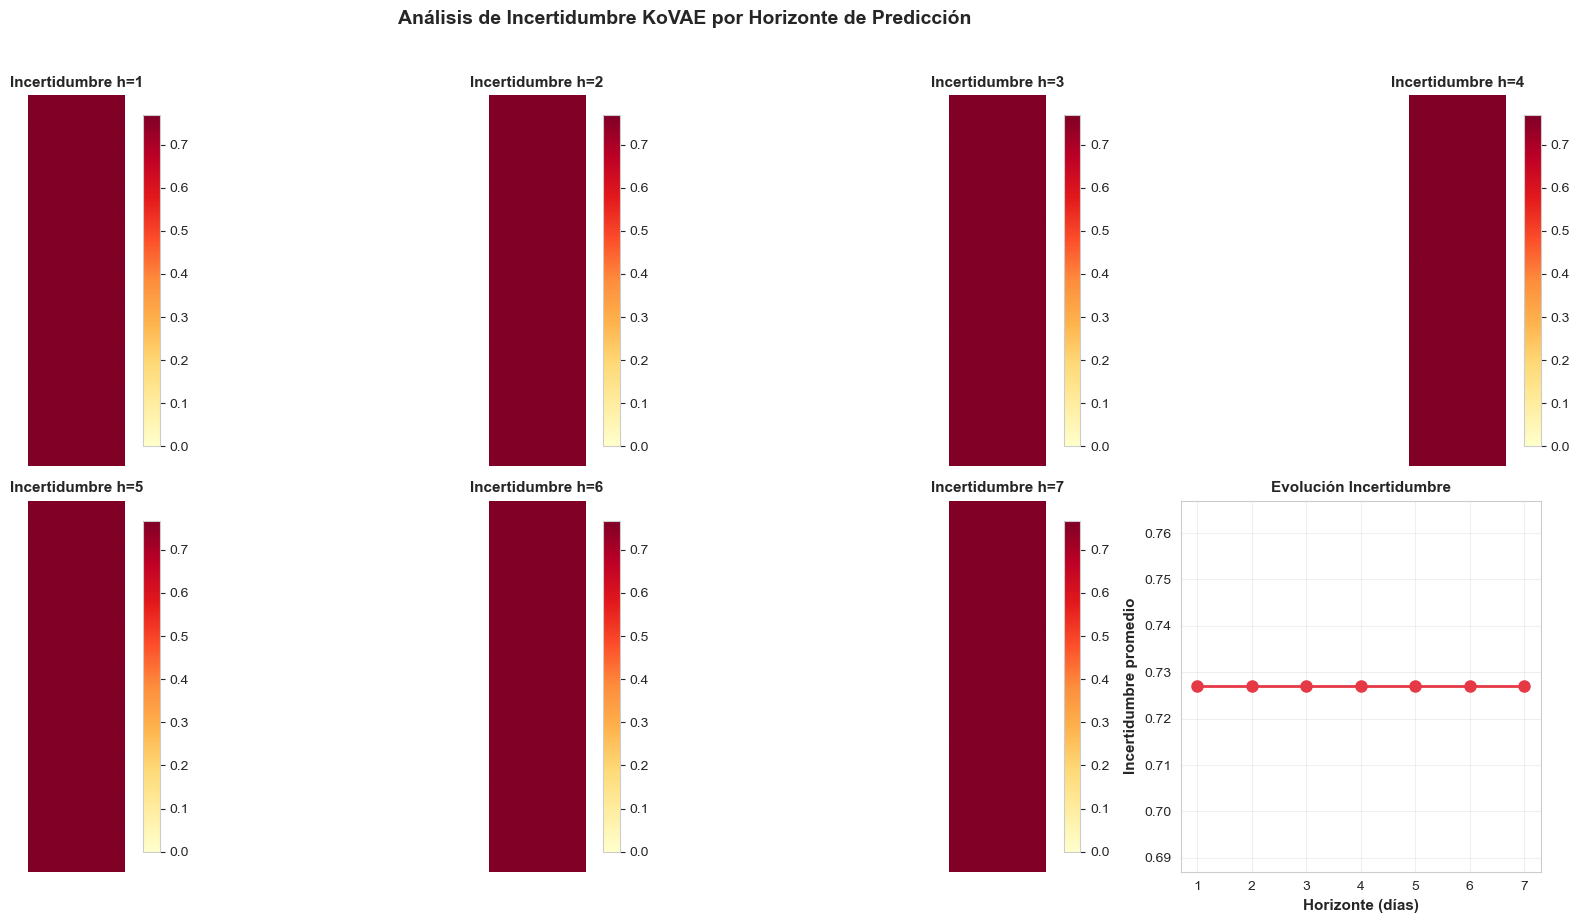

[Guardado] Guardado: ..\reports\figures\kovae_predictions_by_region.png


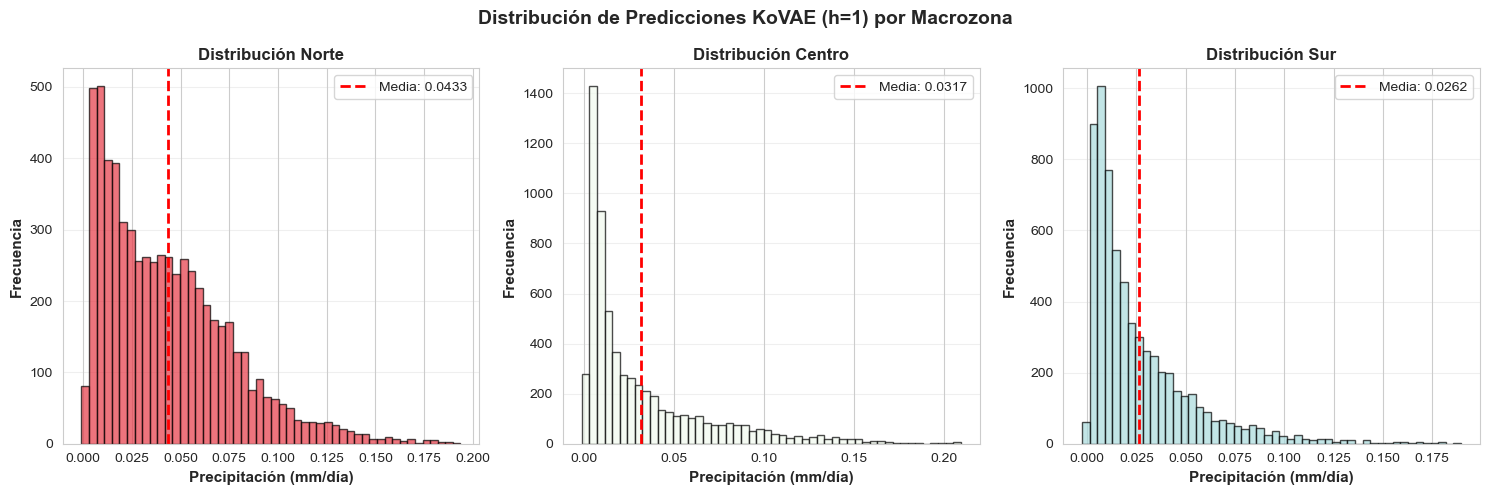


[OK] Visualizaciones de incertidumbre completadas


In [18]:
# ====================================================================================
# 12. VISUALIZACIONES ADICIONALES - AN ÁLISIS DE INCERTIDUMBRE
# ====================================================================================

print("[INFO] Generando visualizaciones de análisis de incertidumbre...")

# 1. Mapas de incertidumbre espacial para diferentes horizontes
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

sample_idx = 0
for h in range(7):
 uncert_map = uncertainties[sample_idx, h, :, :, 0]
 
 im = axes[h].imshow(uncert_map, cmap='YlOrRd', vmin=0, vmax=uncert_map.max())
 axes[h].set_title(f'Incertidumbre h={h+1}', fontsize=11, fontweight='bold')
 axes[h].axis('off')
 plt.colorbar(im, ax=axes[h], fraction=0.046)

# Último subplot: evolución temporal de incertidumbre promedio
uncert_mean_per_horizon = uncertainties.mean(axis=(0, 2, 3, 4))
axes[7].plot(range(1, 8), uncert_mean_per_horizon, 'o-', linewidth=2, markersize=8, color='#E63946')
axes[7].set_xlabel('Horizonte (días)', fontsize=11, fontweight='bold')
axes[7].set_ylabel('Incertidumbre promedio', fontsize=11, fontweight='bold')
axes[7].set_title('Evolución Incertidumbre', fontsize=11, fontweight='bold')
axes[7].grid(True, alpha=0.3)
axes[7].set_xticks(range(1, 8))

plt.suptitle('Análisis de Incertidumbre KoVAE por Horizonte de Predicción', 
 fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_uncertainty_analysis.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_uncertainty_analysis.png'}")
plt.show()

# 2. Distribución de predicciones por región (Norte, Centro, Sur)
lat_shape, lon_shape = predictions.shape[2:4]

# Definir macrozonas
norte_lat = slice(0, lat_shape//3)
centro_lat = slice(lat_shape//3, 2*lat_shape//3)
sur_lat = slice(2*lat_shape//3, lat_shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (region_name, lat_slice) in enumerate([
 ('Norte', norte_lat),
 ('Centro', centro_lat),
 ('Sur', sur_lat)
]):
 # Predicciones h=1 para esa región
 preds_region = predictions[:, 0, lat_slice, :, 0].flatten()
 
 axes[idx].hist(preds_region, bins=50, alpha=0.7, color=['#E63946', '#F1FAEE', '#A8DADC'][idx], edgecolor='black')
 axes[idx].axvline(preds_region.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {preds_region.mean():.4f}')
 axes[idx].set_xlabel('Precipitación (mm/día)', fontsize=11, fontweight='bold')
 axes[idx].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
 axes[idx].set_title(f'Distribución {region_name}', fontsize=12, fontweight='bold')
 axes[idx].legend(fontsize=10)
 axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribución de Predicciones KoVAE (h=1) por Macrozona', 
 fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'kovae_predictions_by_region.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'kovae_predictions_by_region.png'}")
plt.show()

# 3. Mapa de cobertura de intervalos de confianza (% de pixeles bien cubiertos)
# TODO: Requiere ground truth futuro para validar, pendiente de implementación

print("\n[OK] Visualizaciones de incertidumbre completadas")

---
## **13. Serie Temporal con Predicciones**

Visualización de serie temporal comparando:
- Observaciones reales (datos ERA5)
- Predicciones del modelo KoVAE
- Media móvil de 7 días
- Media anual de referencia
- Intervalos de confianza (percentiles 10-90)

In [19]:
# ====================================================================================
# 13. SERIE TEMPORAL CON PREDICCIONES - ESTILO ERA5
# ====================================================================================

print("[INFO] Generando serie temporal con predicciones KoVAE...")

# Verificar que el modelo esté entrenado
if kovae.vae is None:
    print("[ERROR] El modelo KoVAE no está entrenado. Ejecuta las celdas anteriores primero.")
else:
    # Configuración
    n_samples = 50  # Número de muestras (reducido para velocidad)
    
    print(f"[INFO] Generando predicciones para {len(X_test)} días del test set...")
    print(f"[INFO] Generando {n_samples} muestras por punto para intervalos de confianza...")
    
    # Generar predicciones con incertidumbre usando el método del modelo
    all_predictions = []
    for i in range(n_samples):
        # Generar una predicción completa para todo el test set
        preds_i = kovae.vae.predict(X_test, verbose=0)
        all_predictions.append(preds_i[:, :, :, 0])
    
    # Convertir a array numpy (n_samples, n_timesteps, lat, lon)
    all_predictions = np.array(all_predictions)
    print(f"[OK] Predicciones generadas: {all_predictions.shape}")
    
    # Calcular estadísticas espaciales (promedio nacional)
    obs_series = X_test[:, :, :, 0].mean(axis=(1, 2))  # Promedio espacial de observaciones
    pred_mean = all_predictions.mean(axis=(0, 2, 3))  # Media de predicciones
    pred_p10 = np.percentile(all_predictions, 10, axis=0).mean(axis=(1, 2))  # Percentil 10
    pred_p90 = np.percentile(all_predictions, 90, axis=0).mean(axis=(1, 2))  # Percentil 90
    
    # Calcular medias móviles
    window = 7
    obs_rolling = pd.Series(obs_series).rolling(window=window, center=True).mean()
    annual_mean = obs_series.mean()
    
    # Crear fechas para el eje X (últimos días del test set - 37 días)
    dates = pd.date_range('2020-11-24', periods=len(obs_series), freq='D')
    
    print(f"\n[INFO] Estadísticas de la serie:")
    print(f" Observaciones - Media: {obs_series.mean():.3f}, Std: {obs_series.std():.3f}")
    print(f" Predicciones - Media: {pred_mean.mean():.3f}, Std: {pred_mean.std():.3f}")
    print(f" MAE: {np.abs(obs_series - pred_mean).mean():.3f} mm/día")
    print(f" RMSE: {np.sqrt(((obs_series - pred_mean)**2).mean()):.3f} mm/día")

[INFO] Generando serie temporal con predicciones KoVAE...
[INFO] Generando predicciones para 38 días del test set...
[INFO] Generando 50 muestras por punto para intervalos de confianza...
[OK] Predicciones generadas: (50, 38, 157, 41)
[OK] Predicciones generadas: (50, 38, 157, 41)

[INFO] Estadísticas de la serie:
 Observaciones - Media: 0.073, Std: 0.023
 Predicciones - Media: 0.068, Std: 0.017
 MAE: 0.008 mm/día
 RMSE: 0.012 mm/día

[INFO] Estadísticas de la serie:
 Observaciones - Media: 0.073, Std: 0.023
 Predicciones - Media: 0.068, Std: 0.017
 MAE: 0.008 mm/día
 RMSE: 0.012 mm/día



[Guardado] Serie temporal guardada: ..\reports\figures\kovae_timeseries_predictions_era5_style.png


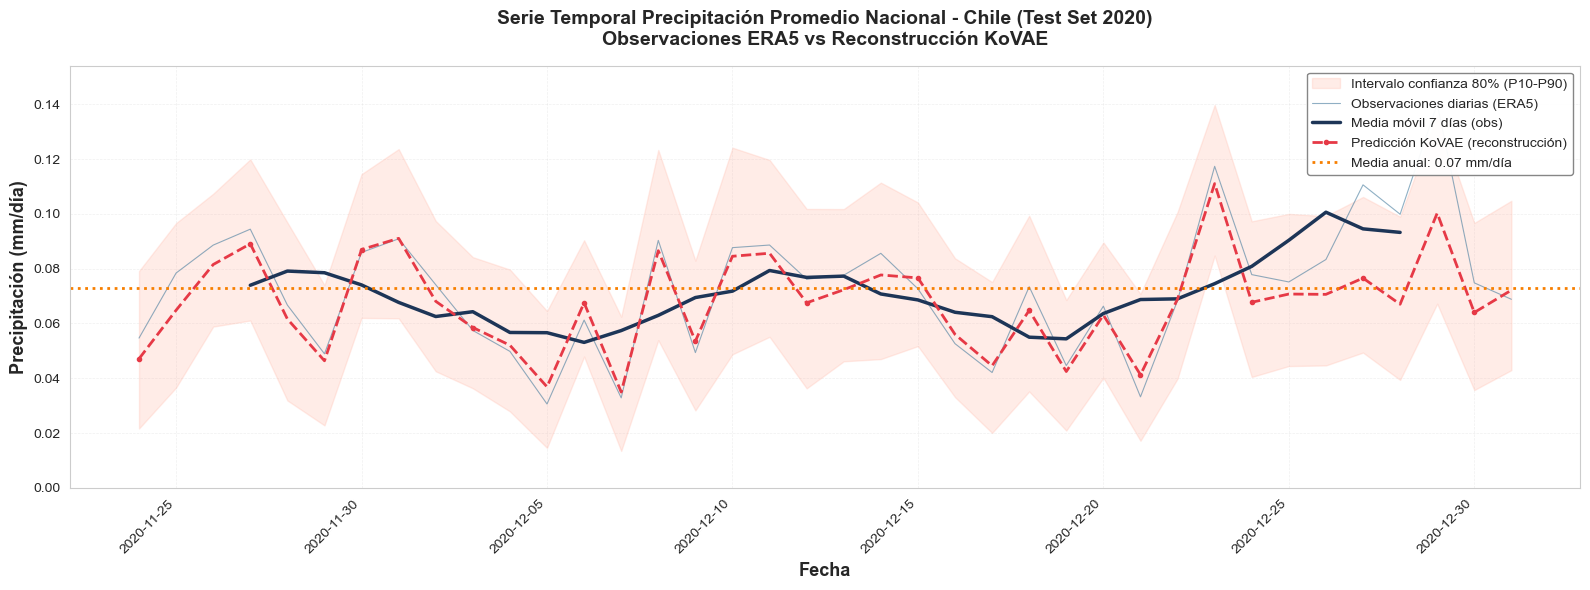


[OK] Visualización de serie temporal completada


In [20]:
# ====================================================================================
# VISUALIZACIÓN: Serie Temporal Estilo ERA5
# ====================================================================================

# Solo ejecutar si las predicciones fueron generadas
if 'all_predictions' in dir() and kovae.vae is not None:
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Colores profesionales
    color_obs = '#457B9D'  # Azul grisáceo para observaciones
    color_pred = '#E63946'  # Rojo para predicciones
    color_rolling = '#1D3557'  # Azul oscuro para media móvil
    color_annual = '#F77F00'  # Naranja para media anual
    color_ci = '#FFB4A2'  # Rosa claro para intervalo de confianza
    
    # 1. Intervalo de confianza (P10-P90) - relleno
    ax.fill_between(dates, pred_p10, pred_p90, 
                    alpha=0.25, color=color_ci, 
                    label='Intervalo confianza 80% (P10-P90)')
    
    # 2. Observaciones diarias (línea delgada)
    ax.plot(dates, obs_series, 
            linewidth=0.8, alpha=0.6, color=color_obs,
            label='Observaciones diarias (ERA5)')
    
    # 3. Media móvil 7 días - observaciones
    ax.plot(dates, obs_rolling, 
            linewidth=2.5, color=color_rolling, 
            label=f'Media móvil {window} días (obs)')
    
    # 4. Predicciones KoVAE (media)
    ax.plot(dates, pred_mean, 
            linewidth=2, color=color_pred, linestyle='--',
            label='Predicción KoVAE (reconstrucción)', marker='o', markersize=3, markevery=3)
    
    # 5. Media anual de referencia (línea punteada horizontal)
    ax.axhline(y=annual_mean, color=color_annual, linestyle=':', 
               linewidth=2, label=f'Media anual: {annual_mean:.2f} mm/día')
    
    # Configuración de ejes y etiquetas
    ax.set_xlabel('Fecha', fontsize=13, fontweight='bold')
    ax.set_ylabel('Precipitación (mm/día)', fontsize=13, fontweight='bold')
    ax.set_title('Serie Temporal Precipitación Promedio Nacional - Chile (Test Set 2020)\nObservaciones ERA5 vs Reconstrucción KoVAE', 
                 fontsize=14, fontweight='bold', pad=15)
    
    # Grid y leyenda
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=10, framealpha=0.95, 
              edgecolor='gray', fancybox=True)
    
    # Formato de fechas en eje X
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.xticks(rotation=45, ha='right')
    
    # Límites del eje Y
    ax.set_ylim(bottom=0, top=max(obs_series.max(), pred_p90.max()) * 1.1)
    
    # Ajustar diseño
    plt.tight_layout()
    
    # Guardar figura
    output_path = FIG_DIR / 'kovae_timeseries_predictions_era5_style.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n[Guardado] Serie temporal guardada: {output_path}")
    
    plt.show()
    
    print("\n" + "="*80)
    print("[OK] Visualización de serie temporal completada")
    print("="*80)
else:
    print("[ERROR] No se pueden generar visualizaciones. Ejecuta las celdas anteriores primero.")


[INFO] Análisis de performance temporal...
[Guardado] Análisis de performance guardado: ..\reports\figures\kovae_performance_analysis.png
[Guardado] Análisis de performance guardado: ..\reports\figures\kovae_performance_analysis.png


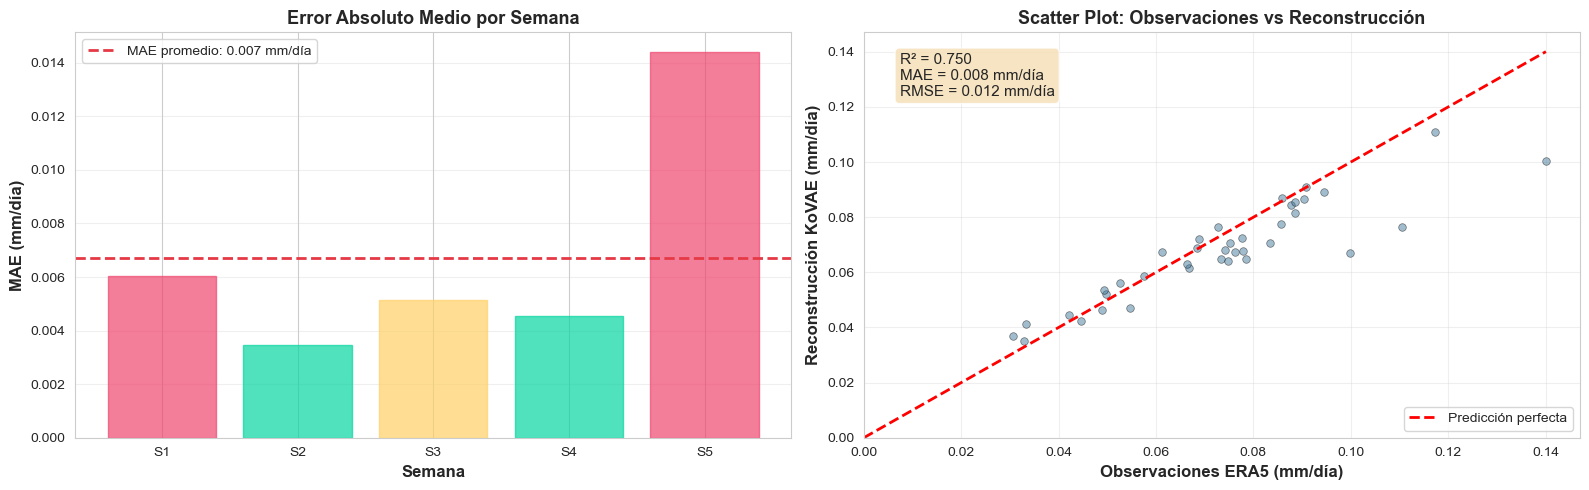


[OK] Análisis de performance completado
 Mejor semana: S2 (MAE = 0.003 mm/día)
 Peor semana: S5 (MAE = 0.014 mm/día)


In [21]:
# ====================================================================================
# ANÁLISIS DE PERFORMANCE POR SUBPERIODO
# ====================================================================================

# Solo ejecutar si las predicciones fueron generadas
if 'all_predictions' in dir() and 'obs_series' in dir():
    print("\n[INFO] Análisis de performance temporal...")
    
    # Dividir la serie en semanas para análisis
    weeks = len(obs_series) // 7
    week_mae = []
    week_labels = []
    
    for w in range(weeks):
        start_idx = w * 7
        end_idx = min((w + 1) * 7, len(obs_series))
        
        obs_week = obs_series[start_idx:end_idx]
        pred_week = pred_mean[start_idx:end_idx]
        
        mae_week = np.abs(obs_week - pred_week).mean()
        week_mae.append(mae_week)
        week_labels.append(f'S{w+1}')
    
    # Visualización de MAE por semana
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Gráfico 1: MAE por semana
    bars = ax1.bar(range(len(week_mae)), week_mae, color='#457B9D', alpha=0.7, edgecolor='black')
    ax1.axhline(y=np.mean(week_mae), color='#E63946', linestyle='--', linewidth=2, 
                label=f'MAE promedio: {np.mean(week_mae):.3f} mm/día')
    ax1.set_xlabel('Semana', fontsize=12, fontweight='bold')
    ax1.set_ylabel('MAE (mm/día)', fontsize=12, fontweight='bold')
    ax1.set_title('Error Absoluto Medio por Semana', fontsize=13, fontweight='bold')
    ax1.set_xticks(range(len(week_mae)))
    ax1.set_xticklabels(week_labels, rotation=0)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.legend(fontsize=10)
    
    # Colorear barras por performance (verde: bueno, amarillo: medio, rojo: malo)
    threshold_good = np.percentile(week_mae, 33)
    threshold_bad = np.percentile(week_mae, 66)
    
    for i, (bar, mae) in enumerate(zip(bars, week_mae)):
        if mae <= threshold_good:
            bar.set_color('#06D6A0')  # Verde
        elif mae <= threshold_bad:
            bar.set_color('#FFD166')  # Amarillo
        else:
            bar.set_color('#EF476F')  # Rojo
    
    # Gráfico 2: Scatter plot obs vs pred
    ax2.scatter(obs_series, pred_mean, alpha=0.5, s=30, color='#457B9D', edgecolors='black', linewidth=0.5)
    ax2.plot([0, obs_series.max()], [0, obs_series.max()], 'r--', linewidth=2, label='Predicción perfecta')
    
    # Calcular R²
    from sklearn.metrics import r2_score
    r2 = r2_score(obs_series, pred_mean)
    mae_total = np.abs(obs_series - pred_mean).mean()
    rmse_total = np.sqrt(((obs_series - pred_mean)**2).mean())
    
    ax2.text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae_total:.3f} mm/día\nRMSE = {rmse_total:.3f} mm/día',
             transform=ax2.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax2.set_xlabel('Observaciones ERA5 (mm/día)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Reconstrucción KoVAE (mm/día)', fontsize=12, fontweight='bold')
    ax2.set_title('Scatter Plot: Observaciones vs Reconstrucción', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_xlim(left=0)
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    output_path = FIG_DIR / 'kovae_performance_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[Guardado] Análisis de performance guardado: {output_path}")
    plt.show()
    
    print("\n[OK] Análisis de performance completado")
    print(f" Mejor semana: {week_labels[np.argmin(week_mae)]} (MAE = {min(week_mae):.3f} mm/día)")
    print(f" Peor semana: {week_labels[np.argmax(week_mae)]} (MAE = {max(week_mae):.3f} mm/día)")
else:
    print("[ERROR] No se puede generar análisis. Ejecuta las celdas anteriores primero.")